## Prepare

In [96]:
# ! python3 -V

In [97]:
# ! pip install -r requirements.txt

In [98]:
# ! wget -O dacapo-bench.jar https://downloads.sourceforge.net/project/dacapobench/9.12-bach-MR1/dacapo-9.12-MR1-bach.jar
# ! wget -O gcviewer-1.36.jar http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20+8/bellsoft-jdk11.0.20+8-linux-amd64.tar.gz
# # MACOS
# # ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-macos-amd64.tar.gz
# # ! wget -O jdk.zip https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-windows-amd64.zip
# # ! wget https://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! tar xzf jdk.tar.gz && rm -fv jdk.tar.gz
# ! java -version

In [99]:
# ! ./jdk-11.0.20/bin/java -jar dacapo/dacapochopin.jar -l

In [100]:
# !  ./jdk-11.0.20/bin/java -jar dacapo-bench.jar xalan

In [101]:
# ! ./jdk-11.0.20/bin/java -XX:+UseParallelGC -Xmx4g -Xms128m  -cp dacapo-bench.jar \
# -Xlog:gc=debug:file=gc-avrora.txt -Dvmstat.enable_jfr=yes \
# -Dvmstat.csv=yes Harness -v -n 5 xalan

In [102]:
# ! pip install gym
# ! mkdir /home/ellkrauze/tmp
# ! export TMPDIR=/home/ellkrauze/tmp && pip install tensorflow
# ! export TMPDIR=/home/ellkrauze/tmp && pip install protobuf==3.20.*
# ! export TMPDIR=/home/ellkrauze/tmp && pip  install --force-reinstall -U tensorflow==2.3.0 keras keras-rl2 h5py==2.10.*


### GCViewer

In [103]:
# # Download jar from http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! java -cp gcviewer-1.36.jar com.tagtraum.perf.gcviewer.GCViewer gc-avrora.txt summary.csv -t SUMMARY

# Tensorflow DQN

In [13]:
import os
import imageio
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network, sequential
from tf_agents.policies import random_tf_policy, policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

# from PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
# from PyEnvironments import JVMEnv
from PyEnvironmentsTest import JVMEnv # !!!

from tf_agents.environments.wrappers import TimeLimit 
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.reinforce import reinforce_agent

from tf_agents.specs import from_spec
# from tf_agents.trajectories import time_step_spec
from tf_agents import trajectories

In [15]:
# JDK used for benchmarking
# TEST_JDK_PATH = "/Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk"
TEST_JDK_PATH = "/home/vsakovskaya/gc-ml/jdk-11.0.20"

# DaCapo benchmark name
BM = "avrora"
BM_TEST = "kafka"
BM_PATH = "/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar"
CALLBACK_PATH = "/home/vsakovskaya/gc-ml/dacapo/DacapoCallback/DacapoChopin/VMStatCallback.java"

# =================
dataset_path = "dataset/data"
tempdir = "tmp"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')
# =================

env = JVMEnv(
    jdk=TEST_JDK_PATH, 
    bm_path=BM_PATH, 
    callback_path=CALLBACK_PATH,
    bm=BM, 
    verbose=True
)

env_test = JVMEnv(
        jdk=TEST_JDK_PATH, 
        bm_path=BM_PATH, 
        callback_path=CALLBACK_PATH,
        bm=BM_TEST,
        verbose=True
    )

# train_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
# eval_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
# test_env = tf_py_environment.TFPyEnvironment(env_test)

## Add wrapper: End episodes after specified number of steps
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/environments/TimeLimit

max_steps = 50

train_env = TimeLimit(env, duration=max_steps)
eval_env = TimeLimit(env, duration=max_steps)
test_env = TimeLimit(env_test, duration=max_steps)

action_spec = from_spec(train_env.action_spec())
observation_spec = from_spec(train_env.observation_spec())
reward_spec = from_spec(train_env.reward_spec())
time_step_spec = trajectories.time_step_spec(observation_spec, reward_spec)

Successfully initialized a JVM Environment!
 JDK: /home/vsakovskaya/gc-ml/jdk-11.0.20/bin,
 Benchmark: avrora (/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,

Successfully initialized a JVM Environment!
 JDK: /home/vsakovskaya/gc-ml/jdk-11.0.20/bin,
 Benchmark: kafka (/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.34],
 Env. default goal value: 0.34,



In [16]:
# fc_layer_params = (100, 50)
# fc_layer_params = (100, 50, 24)
fc_layer_params = (100, 75, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    """
    Define a helper function to create Dense layers configured 
    with the right activation and kernel initializer.
    """
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [17]:
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 10000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}
# replay_buffer_capacity = 10000

# fc_layer_params = (100,)

# batch_size = 64  # @param {type:"integer"}
batch_size = 128  # @param {type:"integer"}
# batch_size = 64  # @param {type:"integer"}
# learning_rate = 1e-3  # @param {type:"number"}
learning_rate = 1e-6
# learning_rate = 1e-7
# gamma = 0.99
gamma = 0.9999 # The discount factor determines the importance of future rewards
gradient_clipping = 1
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 10  # @param {type:"integer"}
# n_step_update = 1  # @param {type:"integer"}

target_update_period = 1000

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
  train_env.time_step_spec(),
  train_env.action_spec(),
  q_network=q_net,
  optimizer=optimizer,
  n_step_update=n_step_update,
  td_errors_loss_fn=tf.keras.losses.MeanSquaredError(),
  epsilon_greedy=0.9,
  # boltzmann_temperature=0.1, # !
  target_update_period=target_update_period, # ??
  gamma=gamma,
  gradient_clipping=gradient_clipping, # [-1, 1]
  train_step_counter=global_step
)

agent.initialize()

random_policy = random_tf_policy.RandomTFPolicy(
  time_step_spec = train_env.time_step_spec(),
  action_spec = train_env.action_spec(),
  automatic_state_reset=True,
  clip=False
)

TypeError: Spec type not supported: 'BoundedArraySpec(shape=(2,), dtype=dtype('int64'), name='observation', minimum=[1 4], maximum=[16 24])'
  In call to configurable 'DqnAgent' (<class 'tf_agents.agents.dqn.dqn_agent.DqnAgent'>)

## Data Collection

In [5]:
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    reward = 0
    try:
        next_time_step = environment.step(action_step.action)
        reward = next_time_step.reward
        traj = trajectory.from_transition(time_step, action_step, next_time_step)
        replay_buffer.add_batch(traj)
        trajectories.append([traj.observation, env._reward])
    except ValueError:
        pass
    return reward


def save_dataset(data, path):
    step_counter = tf.Variable(0, trainable=False)
    checkpoint_prefix = "checkpoint"
    checkpoint_args = {
        "checkpoint_interval": 50,
        "step_counter": step_counter,
        "directory": checkpoint_prefix,
        "max_to_keep": 3,
    }
    try:
        data.save(path, checkpoint_args=checkpoint_args)
    except:
        pass

def save_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).save(path)

def restore_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).restore(path)


In [6]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

tf_policy_saver = policy_saver.PolicySaver(agent.policy)
replay_buffer_observer = replay_buffer.add_batch

collect_dataset = True
trajectories = []

if collect_dataset:
    for _ in tqdm(range(initial_collect_steps)):
        collect_step(train_env, random_policy)
    save_rb(replay_buffer, dataset_path)
else: 
    restore_rb(replay_buffer, dataset_path+'-1')

100%|██████████| 10000/10000 [00:55<00:00, 181.16it/s]


In [7]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size,
    num_steps=n_step_update + 1, 
    single_deterministic_pass=False).prefetch(3)

# dataset = replay_buffer.as_dataset(
#     num_parallel_calls=3,
#     sample_batch_size=batch_size,
#     num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


### Visualize Dataset

In [111]:
x = []
y = []
pairs = []
rews = []
for each in trajectories:
    pairs.append(each[0].numpy()[0])
    x.append(each[0][0][0].numpy())
    y.append(each[0][0][1].numpy())
    rews.append(each[1])
    # print(each[1])

# rewards_df = pd.DataFrame(pairs, rews, columns=["MaxTenuringThreshold", "ParallelGCThreads"])
# rewards_df = rewards_df.reset_index()
# rewards_df = rewards_df.rename(columns={'index': 'reward'})

# rewards_df.sort_values(by='reward', ascending=False)

<Axes: title={'center': 'Frequency of flag pairs in a dataset'}, xlabel='MaxTenuringThreshold,ParallelGCThreads'>

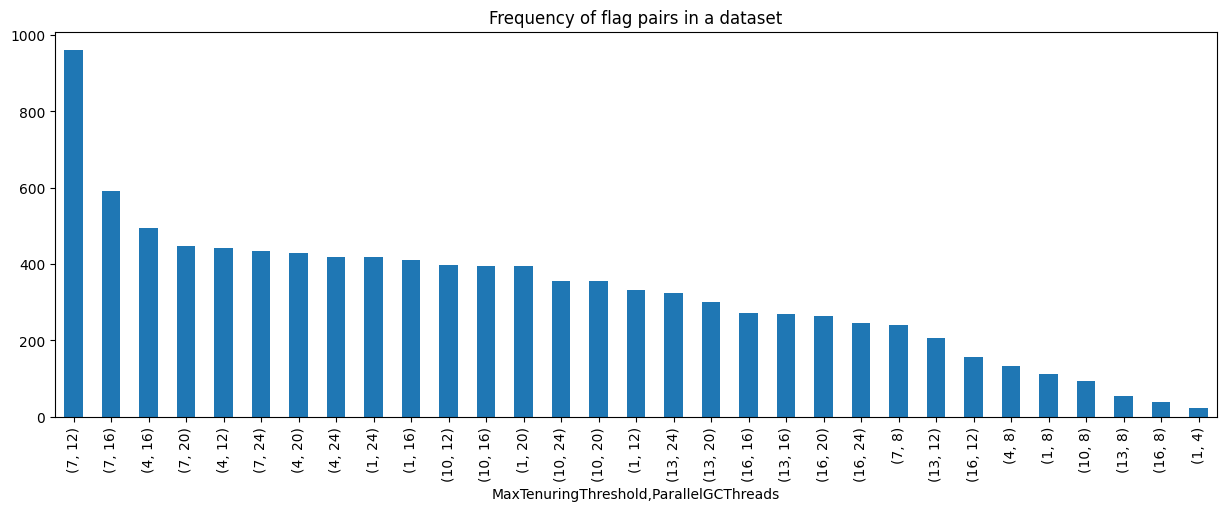

In [112]:
import pandas as pd

df = pd.DataFrame(pairs, columns=["MaxTenuringThreshold", "ParallelGCThreads"])
df.value_counts().head(100).plot(figsize=(15,5), kind='bar', title="Frequency of flag pairs in a dataset")

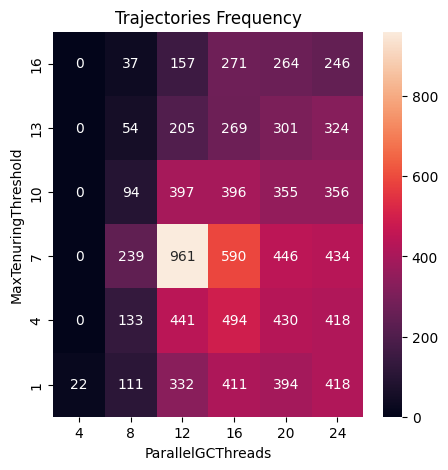

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(5, 5))
x = df.pivot_table(index='MaxTenuringThreshold',columns='ParallelGCThreads',aggfunc='size',fill_value=0)
idx = x.max(axis=1).sort_values(ascending=0).index
sns.heatmap(x, annot=True, ax=ax, fmt="")
ax.set_title("Trajectories Frequency")
ax.invert_yaxis()
plt.show()

Plot data as heatmap.

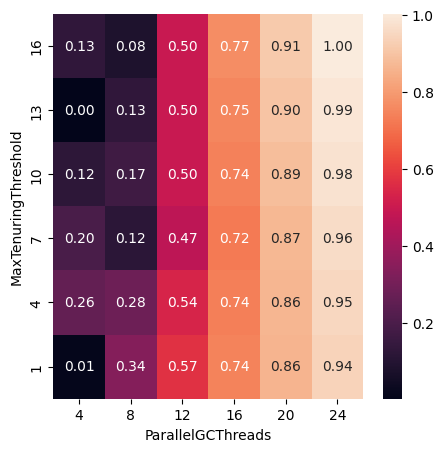

In [114]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
cached_states = env._perf_states
X = [cached_states[i]["args"][0] for i in cached_states.keys()]
Y = [cached_states[i]["args"][1] for i in cached_states.keys()]
Z = [cached_states[i]["goal"] for i in cached_states.keys()]

data = pd.DataFrame({'MaxTenuringThreshold': X, 'ParallelGCThreads': Y, 'Average GC Pause': Z})
data_pivoted = data.pivot("MaxTenuringThreshold", "ParallelGCThreads", "Average GC Pause")
ax = sns.heatmap(data_pivoted, annot=True, ax=ax, fmt=".2f")
ax.invert_yaxis()
plt.show()

## Agent Training

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

Note that one other significant difference from vanilla `DqnAgent` is that we now need to specify `min_q_value` and `max_q_value` as arguments. These specify the most extreme values of the support (in other words, the most extreme of the 51 atoms on either side). Make sure to choose these appropriately for your particular environment. Here we use -20 and 20.

In [8]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  time_step = environment.reset()
  episode_return = 0.0
  for _ in tqdm(range(num_episodes)):

    action_step = policy.action(time_step, seed=42)
    time_step = environment.step(action_step.action)
    # print(f"time_step = {time_step.observation}")
    episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [9]:
agent.train = common.function(agent.train)
# Reset the train step
agent.train_step_counter.assign(0)
agent.initialize()

# Evaluate the agent's policy once before training.
# avg_return = compute_avg_return(eval_env, agent.policy, 100)
# returns = [avg_return]

loss = []
returns = []
observations = []
rewards = []
time_step = None
eval_interval = 100 
loss_interval = 100
total_return = 0.0
# time_step = None
time_step = eval_env.reset()
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)

# for _ in tqdm(range(100)):
for _ in tqdm(range(15000)):
  # Sample a batch of data from the buffer and update the agent's network.
  # time_step, _ = collect_driver.run(time_step)

  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.policy)

  experience, buffer_info = next(iterator)
  train_loss = agent.train(experience)

  # Calculate a reward
  policy_step = agent.policy.action(time_step, seed=42)
  time_step = eval_env.step(policy_step.action)
  rwd = time_step.reward.numpy()[0]
  obs = time_step.observation.numpy()[0]
  total_return += rwd # Calculate a sum of rewards

  step = agent.train_step_counter.numpy()

  # Log
  # print(f"step = {step}: observation = {obs}, reward = {rwd}")
  observations.append(obs)
  rewards.append(rwd)
  
  if step % loss_interval == 0:
    print(f"step = {step}: loss = {train_loss.loss}")
    loss.append(train_loss.loss)

  if step % eval_interval == 0:
    # avg_return = compute_avg_return(eval_env, agent.policy, 10)
    avg_return = total_return / eval_interval
    print('step = {0}: Average reward = {1:.5f}'.format(step, avg_return))
    returns.append(avg_return)
    total_return = 0.0 # reset

  0%|          | 0/15000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  1%|          | 107/15000 [00:03<05:05, 48.83it/s]

step = 100: loss = 5.767751693725586
step = 100: Average reward = -0.44136


  1%|▏         | 205/15000 [00:05<04:54, 50.17it/s]

step = 200: loss = 4.877603054046631
step = 200: Average reward = -0.45136


  2%|▏         | 306/15000 [00:07<04:42, 51.99it/s]

step = 300: loss = 4.724057197570801
step = 300: Average reward = -0.44474


  3%|▎         | 408/15000 [00:09<04:37, 52.63it/s]

step = 400: loss = 4.157114505767822
step = 400: Average reward = -0.44136


  3%|▎         | 509/15000 [00:10<04:48, 50.15it/s]

step = 500: loss = 3.9783217906951904
step = 500: Average reward = -0.45136


  4%|▍         | 611/15000 [00:12<04:23, 54.69it/s]

step = 600: loss = 3.67626953125
step = 600: Average reward = -0.44474


  5%|▍         | 708/15000 [00:14<04:29, 52.96it/s]

step = 700: loss = 3.2763941287994385
step = 700: Average reward = -0.44136


  5%|▌         | 805/15000 [00:16<04:31, 52.23it/s]

step = 800: loss = 3.181464672088623
step = 800: Average reward = -0.45136


  6%|▌         | 905/15000 [00:18<04:16, 54.93it/s]

step = 900: loss = 3.001673698425293
step = 900: Average reward = -0.44474


  7%|▋         | 1007/15000 [00:20<04:11, 55.73it/s]

step = 1000: loss = 2.7197704315185547
step = 1000: Average reward = -0.44136


  7%|▋         | 1107/15000 [00:22<04:37, 50.07it/s]

step = 1100: loss = 2.25256085395813
step = 1100: Average reward = -0.45136


  8%|▊         | 1203/15000 [00:24<04:15, 54.02it/s]

step = 1200: loss = 2.3205504417419434
step = 1200: Average reward = -0.44474


  9%|▊         | 1309/15000 [00:26<04:17, 53.12it/s]

step = 1300: loss = 2.046954870223999
step = 1300: Average reward = -0.44136


  9%|▉         | 1408/15000 [00:28<04:44, 47.83it/s]

step = 1400: loss = 1.792637825012207
step = 1400: Average reward = -0.45136


 10%|█         | 1510/15000 [00:30<04:24, 50.97it/s]

step = 1500: loss = 1.562575101852417
step = 1500: Average reward = -0.44474


 11%|█         | 1605/15000 [00:32<04:47, 46.59it/s]

step = 1600: loss = 1.6109726428985596
step = 1600: Average reward = -0.44136


 11%|█▏        | 1705/15000 [00:34<04:43, 46.95it/s]

step = 1700: loss = 1.3449878692626953
step = 1700: Average reward = -0.45136


 12%|█▏        | 1811/15000 [00:36<04:14, 51.82it/s]

step = 1800: loss = 1.1478283405303955
step = 1800: Average reward = -0.44474


 13%|█▎        | 1905/15000 [00:38<04:30, 48.41it/s]

step = 1900: loss = 0.9713531732559204
step = 1900: Average reward = -0.44136


 13%|█▎        | 2009/15000 [00:40<04:01, 53.87it/s]

step = 2000: loss = 0.8970030546188354
step = 2000: Average reward = -0.45136


 14%|█▍        | 2105/15000 [00:42<03:55, 54.71it/s]

step = 2100: loss = 0.7501896023750305
step = 2100: Average reward = -0.44474


 15%|█▍        | 2208/15000 [00:44<04:03, 52.50it/s]

step = 2200: loss = 0.701718270778656
step = 2200: Average reward = -0.44136


 15%|█▌        | 2307/15000 [00:46<04:21, 48.56it/s]

step = 2300: loss = 0.4972386956214905
step = 2300: Average reward = -0.45136


 16%|█▌        | 2409/15000 [00:48<03:55, 53.55it/s]

step = 2400: loss = 0.5164756178855896
step = 2400: Average reward = -0.44474


 17%|█▋        | 2510/15000 [00:49<03:49, 54.40it/s]

step = 2500: loss = 0.45184969902038574
step = 2500: Average reward = -0.44136


 17%|█▋        | 2605/15000 [00:51<04:10, 49.49it/s]

step = 2600: loss = 0.3958074748516083
step = 2600: Average reward = -0.44416


 18%|█▊        | 2708/15000 [00:53<04:05, 50.01it/s]

step = 2700: loss = 0.3121107220649719
step = 2700: Average reward = -0.43241


 19%|█▊        | 2804/15000 [00:55<04:04, 49.92it/s]

step = 2800: loss = 0.3252749443054199
step = 2800: Average reward = -0.42241


 19%|█▉        | 2905/15000 [00:57<03:57, 51.02it/s]

step = 2900: loss = 0.22143812477588654
step = 2900: Average reward = -0.16641


 20%|██        | 3007/15000 [00:59<03:45, 53.22it/s]

step = 3000: loss = 0.28647735714912415
step = 3000: Average reward = 0.00000


 21%|██        | 3107/15000 [01:01<03:57, 50.17it/s]

step = 3100: loss = 0.23875637352466583
step = 3100: Average reward = 0.00000


 21%|██▏       | 3207/15000 [01:03<03:34, 55.06it/s]

step = 3200: loss = 0.22587791085243225
step = 3200: Average reward = 0.00000


 22%|██▏       | 3309/15000 [01:05<03:43, 52.38it/s]

step = 3300: loss = 0.23799848556518555
step = 3300: Average reward = 0.00000


 23%|██▎       | 3406/15000 [01:07<03:42, 52.17it/s]

step = 3400: loss = 0.2282748967409134
step = 3400: Average reward = 0.00000


 23%|██▎       | 3506/15000 [01:09<03:43, 51.39it/s]

step = 3500: loss = 0.2618260979652405
step = 3500: Average reward = 0.00000


 24%|██▍       | 3608/15000 [01:11<03:39, 51.91it/s]

step = 3600: loss = 0.22115400433540344
step = 3600: Average reward = 0.00000


 25%|██▍       | 3710/15000 [01:13<03:36, 52.10it/s]

step = 3700: loss = 0.30291247367858887
step = 3700: Average reward = 0.00000


 25%|██▌       | 3806/15000 [01:15<03:40, 50.77it/s]

step = 3800: loss = 0.23830556869506836
step = 3800: Average reward = 0.00000


 26%|██▌       | 3908/15000 [01:17<03:38, 50.78it/s]

step = 3900: loss = 0.25648626685142517
step = 3900: Average reward = 0.00000


 27%|██▋       | 4010/15000 [01:19<03:14, 56.54it/s]

step = 4000: loss = 0.22280143201351166
step = 4000: Average reward = 0.00000


 27%|██▋       | 4111/15000 [01:20<03:17, 55.03it/s]

step = 4100: loss = 0.249253511428833
step = 4100: Average reward = 0.00000


 28%|██▊       | 4207/15000 [01:22<03:16, 54.94it/s]

step = 4200: loss = 0.2446650266647339
step = 4200: Average reward = 0.00000


 29%|██▊       | 4306/15000 [01:24<03:20, 53.25it/s]

step = 4300: loss = 0.2679591774940491
step = 4300: Average reward = 0.00000


 29%|██▉       | 4407/15000 [01:26<03:18, 53.46it/s]

step = 4400: loss = 0.20024918019771576
step = 4400: Average reward = 0.00000


 30%|███       | 4509/15000 [01:28<03:13, 54.26it/s]

step = 4500: loss = 0.2966592609882355
step = 4500: Average reward = 0.00000


 31%|███       | 4608/15000 [01:30<03:41, 46.97it/s]

step = 4600: loss = 0.254754900932312
step = 4600: Average reward = 0.00000


 31%|███▏      | 4711/15000 [01:32<03:06, 55.24it/s]

step = 4700: loss = 0.19920659065246582
step = 4700: Average reward = 0.00000


 32%|███▏      | 4807/15000 [01:34<03:22, 50.31it/s]

step = 4800: loss = 0.18237891793251038
step = 4800: Average reward = 0.00000


 33%|███▎      | 4908/15000 [01:36<03:15, 51.58it/s]

step = 4900: loss = 0.24695873260498047
step = 4900: Average reward = 0.00000


 33%|███▎      | 5009/15000 [01:38<03:05, 53.98it/s]

step = 5000: loss = 0.23848268389701843
step = 5000: Average reward = 0.00000


 34%|███▍      | 5107/15000 [01:40<03:31, 46.76it/s]

step = 5100: loss = 0.1963067501783371
step = 5100: Average reward = 0.00000


 35%|███▍      | 5206/15000 [01:42<03:16, 49.73it/s]

step = 5200: loss = 0.22044037282466888
step = 5200: Average reward = 0.00000


 35%|███▌      | 5306/15000 [01:44<03:10, 50.84it/s]

step = 5300: loss = 0.2266373634338379
step = 5300: Average reward = 0.00000


 36%|███▌      | 5408/15000 [01:46<02:56, 54.32it/s]

step = 5400: loss = 0.25458040833473206
step = 5400: Average reward = 0.00000


 37%|███▋      | 5510/15000 [01:48<02:58, 53.29it/s]

step = 5500: loss = 0.26044195890426636
step = 5500: Average reward = 0.00000


 37%|███▋      | 5606/15000 [01:49<03:06, 50.26it/s]

step = 5600: loss = 0.2516132593154907
step = 5600: Average reward = 0.00000


 38%|███▊      | 5706/15000 [01:51<03:15, 47.42it/s]

step = 5700: loss = 0.2050630748271942
step = 5700: Average reward = 0.00000


 39%|███▊      | 5808/15000 [01:53<03:00, 50.92it/s]

step = 5800: loss = 0.22165174782276154
step = 5800: Average reward = 0.00000


 39%|███▉      | 5905/15000 [01:55<02:51, 53.17it/s]

step = 5900: loss = 0.17582359910011292
step = 5900: Average reward = 0.00000


 40%|████      | 6004/15000 [01:57<03:19, 45.20it/s]

step = 6000: loss = 0.1943175196647644
step = 6000: Average reward = 0.00000


 41%|████      | 6106/15000 [01:59<02:57, 50.11it/s]

step = 6100: loss = 0.24312475323677063
step = 6100: Average reward = 0.00000


 41%|████▏     | 6208/15000 [02:01<03:40, 39.92it/s]

step = 6200: loss = 0.17554455995559692
step = 6200: Average reward = 0.00000


 42%|████▏     | 6309/15000 [02:03<02:55, 49.64it/s]

step = 6300: loss = 0.26327329874038696
step = 6300: Average reward = 0.00000


 43%|████▎     | 6408/15000 [02:05<02:57, 48.31it/s]

step = 6400: loss = 0.19763551652431488
step = 6400: Average reward = 0.00000


 43%|████▎     | 6504/15000 [02:07<02:43, 52.07it/s]

step = 6500: loss = 0.20483675599098206
step = 6500: Average reward = 0.00000


 44%|████▍     | 6606/15000 [02:09<02:33, 54.69it/s]

step = 6600: loss = 0.20302143692970276
step = 6600: Average reward = 0.00000


 45%|████▍     | 6708/15000 [02:11<02:30, 55.13it/s]

step = 6700: loss = 0.2546977400779724
step = 6700: Average reward = 0.00000


 45%|████▌     | 6804/15000 [02:13<02:54, 46.89it/s]

step = 6800: loss = 0.19023916125297546
step = 6800: Average reward = 0.00000


 46%|████▌     | 6905/15000 [02:15<02:40, 50.37it/s]

step = 6900: loss = 0.1985391527414322
step = 6900: Average reward = 0.00000


 47%|████▋     | 7007/15000 [02:17<02:30, 52.94it/s]

step = 7000: loss = 0.1895948052406311
step = 7000: Average reward = 0.00000


 47%|████▋     | 7109/15000 [02:19<02:19, 56.41it/s]

step = 7100: loss = 0.22738462686538696
step = 7100: Average reward = 0.00000


 48%|████▊     | 7210/15000 [02:21<02:28, 52.39it/s]

step = 7200: loss = 0.1887756884098053
step = 7200: Average reward = 0.00000


 49%|████▊     | 7306/15000 [02:22<02:29, 51.43it/s]

step = 7300: loss = 0.19201019406318665
step = 7300: Average reward = 0.00000


 49%|████▉     | 7407/15000 [02:24<02:23, 52.84it/s]

step = 7400: loss = 0.1911662220954895
step = 7400: Average reward = 0.00000


 50%|█████     | 7508/15000 [02:26<02:20, 53.33it/s]

step = 7500: loss = 0.23437580466270447
step = 7500: Average reward = 0.00000


 51%|█████     | 7605/15000 [02:28<02:28, 49.70it/s]

step = 7600: loss = 0.21802222728729248
step = 7600: Average reward = 0.00000


 51%|█████▏    | 7706/15000 [02:30<02:17, 52.93it/s]

step = 7700: loss = 0.19671529531478882
step = 7700: Average reward = 0.00000


 52%|█████▏    | 7810/15000 [02:32<02:12, 54.22it/s]

step = 7800: loss = 0.2034529149532318
step = 7800: Average reward = 0.00000


 53%|█████▎    | 7906/15000 [02:34<02:13, 53.30it/s]

step = 7900: loss = 0.21563568711280823
step = 7900: Average reward = 0.00000


 53%|█████▎    | 8011/15000 [02:36<02:13, 52.38it/s]

step = 8000: loss = 0.19773685932159424
step = 8000: Average reward = 0.00000


 54%|█████▍    | 8107/15000 [02:38<02:10, 52.71it/s]

step = 8100: loss = 0.2047230303287506
step = 8100: Average reward = 0.00000


 55%|█████▍    | 8209/15000 [02:40<02:05, 53.93it/s]

step = 8200: loss = 0.21313127875328064
step = 8200: Average reward = 0.00000


 55%|█████▌    | 8305/15000 [02:42<02:09, 51.60it/s]

step = 8300: loss = 0.16955995559692383
step = 8300: Average reward = 0.00000


 56%|█████▌    | 8405/15000 [02:44<02:00, 54.73it/s]

step = 8400: loss = 0.2077399492263794
step = 8400: Average reward = 0.00000


 57%|█████▋    | 8507/15000 [02:46<02:04, 52.09it/s]

step = 8500: loss = 0.2131040096282959
step = 8500: Average reward = 0.00000


 57%|█████▋    | 8607/15000 [02:48<02:06, 50.62it/s]

step = 8600: loss = 0.1810508370399475
step = 8600: Average reward = 0.00000


 58%|█████▊    | 8706/15000 [02:50<02:10, 48.14it/s]

step = 8700: loss = 0.190867617726326
step = 8700: Average reward = 0.00000


 59%|█████▊    | 8808/15000 [02:52<01:52, 55.20it/s]

step = 8800: loss = 0.22751003503799438
step = 8800: Average reward = 0.00000


 59%|█████▉    | 8910/15000 [02:53<01:49, 55.42it/s]

step = 8900: loss = 0.1426641047000885
step = 8900: Average reward = 0.00000


 60%|██████    | 9006/15000 [02:55<01:53, 52.82it/s]

step = 9000: loss = 0.2185361683368683
step = 9000: Average reward = 0.00000


 61%|██████    | 9108/15000 [02:57<01:54, 51.41it/s]

step = 9100: loss = 0.2702484726905823
step = 9100: Average reward = 0.00000


 61%|██████▏   | 9210/15000 [02:59<01:42, 56.72it/s]

step = 9200: loss = 0.17651623487472534
step = 9200: Average reward = 0.00000


 62%|██████▏   | 9306/15000 [03:01<01:51, 50.91it/s]

step = 9300: loss = 0.20367006957530975
step = 9300: Average reward = 0.00000


 63%|██████▎   | 9408/15000 [03:03<01:47, 51.91it/s]

step = 9400: loss = 0.19367383420467377
step = 9400: Average reward = 0.00000


 63%|██████▎   | 9510/15000 [03:05<01:45, 51.91it/s]

step = 9500: loss = 0.15864232182502747
step = 9500: Average reward = 0.00000


 64%|██████▍   | 9610/15000 [03:07<01:42, 52.47it/s]

step = 9600: loss = 0.1384599804878235
step = 9600: Average reward = 0.00000


 65%|██████▍   | 9706/15000 [03:09<01:37, 54.24it/s]

step = 9700: loss = 0.14898259937763214
step = 9700: Average reward = 0.00000


 65%|██████▌   | 9806/15000 [03:11<01:50, 46.99it/s]

step = 9800: loss = 0.1887442171573639
step = 9800: Average reward = 0.00000


 66%|██████▌   | 9908/15000 [03:13<01:36, 52.66it/s]

step = 9900: loss = 0.21342670917510986
step = 9900: Average reward = 0.00000


 67%|██████▋   | 10008/15000 [03:14<01:34, 53.03it/s]

step = 10000: loss = 0.20527292788028717
step = 10000: Average reward = 0.00000


 67%|██████▋   | 10106/15000 [03:16<01:37, 50.25it/s]

step = 10100: loss = 0.18542417883872986
step = 10100: Average reward = 0.00000


 68%|██████▊   | 10205/15000 [03:18<01:37, 49.06it/s]

step = 10200: loss = 0.19302546977996826
step = 10200: Average reward = 0.00000


 69%|██████▊   | 10307/15000 [03:20<01:23, 56.27it/s]

step = 10300: loss = 0.1850731372833252
step = 10300: Average reward = 0.00000


 69%|██████▉   | 10408/15000 [03:22<01:28, 51.84it/s]

step = 10400: loss = 0.17680278420448303
step = 10400: Average reward = 0.00000


 70%|███████   | 10504/15000 [03:24<01:36, 46.52it/s]

step = 10500: loss = 0.10110980272293091
step = 10500: Average reward = 0.00000


 71%|███████   | 10608/15000 [03:26<01:27, 50.05it/s]

step = 10600: loss = 0.2118913233280182
step = 10600: Average reward = 0.00000


 71%|███████▏  | 10709/15000 [03:28<01:17, 55.72it/s]

step = 10700: loss = 0.16715332865715027
step = 10700: Average reward = 0.00000


 72%|███████▏  | 10809/15000 [03:30<01:17, 53.98it/s]

step = 10800: loss = 0.13631001114845276
step = 10800: Average reward = 0.00000


 73%|███████▎  | 10909/15000 [03:32<01:24, 48.62it/s]

step = 10900: loss = 0.18181392550468445
step = 10900: Average reward = 0.00000


 73%|███████▎  | 11007/15000 [03:34<01:19, 50.15it/s]

step = 11000: loss = 0.20906710624694824
step = 11000: Average reward = 0.00000


 74%|███████▍  | 11109/15000 [03:36<01:18, 49.69it/s]

step = 11100: loss = 0.18790635466575623
step = 11100: Average reward = 0.00000


 75%|███████▍  | 11205/15000 [03:38<01:17, 49.12it/s]

step = 11200: loss = 0.1352839469909668
step = 11200: Average reward = 0.00000


 75%|███████▌  | 11305/15000 [03:40<01:13, 50.23it/s]

step = 11300: loss = 0.13833893835544586
step = 11300: Average reward = 0.00000


 76%|███████▌  | 11407/15000 [03:42<01:05, 54.64it/s]

step = 11400: loss = 0.18642807006835938
step = 11400: Average reward = 0.00000


 77%|███████▋  | 11509/15000 [03:44<01:09, 50.04it/s]

step = 11500: loss = 0.21454600989818573
step = 11500: Average reward = 0.00000


 77%|███████▋  | 11610/15000 [03:46<01:02, 54.34it/s]

step = 11600: loss = 0.20631994307041168
step = 11600: Average reward = 0.00000


 78%|███████▊  | 11709/15000 [03:48<00:59, 55.66it/s]

step = 11700: loss = 0.13665799796581268
step = 11700: Average reward = 0.00000


 79%|███████▊  | 11807/15000 [03:50<01:04, 49.75it/s]

step = 11800: loss = 0.1748683750629425
step = 11800: Average reward = 0.00000


 79%|███████▉  | 11906/15000 [03:52<00:59, 52.08it/s]

step = 11900: loss = 0.14177006483078003
step = 11900: Average reward = 0.00000


 80%|████████  | 12008/15000 [03:53<00:55, 53.45it/s]

step = 12000: loss = 0.1418253779411316
step = 12000: Average reward = 0.00000


 81%|████████  | 12110/15000 [03:55<00:56, 51.44it/s]

step = 12100: loss = 0.1711805909872055
step = 12100: Average reward = 0.00000


 81%|████████▏ | 12209/15000 [03:57<00:57, 48.29it/s]

step = 12200: loss = 0.14691954851150513
step = 12200: Average reward = 0.00000


 82%|████████▏ | 12310/15000 [03:59<00:52, 51.13it/s]

step = 12300: loss = 0.14759457111358643
step = 12300: Average reward = 0.00000


 83%|████████▎ | 12405/15000 [04:01<00:48, 53.71it/s]

step = 12400: loss = 0.18972787261009216
step = 12400: Average reward = 0.00000


 83%|████████▎ | 12510/15000 [04:03<00:47, 52.57it/s]

step = 12500: loss = 0.15912777185440063
step = 12500: Average reward = 0.00000


 84%|████████▍ | 12606/15000 [04:05<00:42, 56.19it/s]

step = 12600: loss = 0.1526067852973938
step = 12600: Average reward = 0.00000


 85%|████████▍ | 12708/15000 [04:07<00:40, 56.89it/s]

step = 12700: loss = 0.1750449240207672
step = 12700: Average reward = 0.00000


 85%|████████▌ | 12804/15000 [04:09<00:43, 50.93it/s]

step = 12800: loss = 0.14300279319286346
step = 12800: Average reward = 0.00000


 86%|████████▌ | 12908/15000 [04:11<00:45, 45.67it/s]

step = 12900: loss = 0.15246394276618958
step = 12900: Average reward = 0.00000


 87%|████████▋ | 13010/15000 [04:13<00:36, 53.80it/s]

step = 13000: loss = 0.14286015927791595
step = 13000: Average reward = 0.00000


 87%|████████▋ | 13106/15000 [04:15<00:35, 52.88it/s]

step = 13100: loss = 0.0909244567155838
step = 13100: Average reward = 0.00000


 88%|████████▊ | 13208/15000 [04:17<00:33, 53.54it/s]

step = 13200: loss = 0.12858976423740387
step = 13200: Average reward = 0.00000


 89%|████████▊ | 13310/15000 [04:19<00:29, 57.25it/s]

step = 13300: loss = 0.11665615439414978
step = 13300: Average reward = 0.00000


 89%|████████▉ | 13407/15000 [04:20<00:28, 55.34it/s]

step = 13400: loss = 0.13490137457847595
step = 13400: Average reward = 0.00000


 90%|█████████ | 13507/15000 [04:22<00:30, 49.46it/s]

step = 13500: loss = 0.1296231597661972
step = 13500: Average reward = 0.00000


 91%|█████████ | 13609/15000 [04:24<00:25, 54.29it/s]

step = 13600: loss = 0.14902180433273315
step = 13600: Average reward = 0.00000


 91%|█████████▏| 13710/15000 [04:26<00:26, 49.24it/s]

step = 13700: loss = 0.1497194468975067
step = 13700: Average reward = 0.00000


 92%|█████████▏| 13810/15000 [04:28<00:21, 56.33it/s]

step = 13800: loss = 0.1447761356830597
step = 13800: Average reward = 0.00000


 93%|█████████▎| 13906/15000 [04:30<00:20, 52.76it/s]

step = 13900: loss = 0.18731702864170074
step = 13900: Average reward = 0.00000


 93%|█████████▎| 14008/15000 [04:32<00:18, 52.96it/s]

step = 14000: loss = 0.16126026213169098
step = 14000: Average reward = 0.00000


 94%|█████████▍| 14110/15000 [04:34<00:16, 54.03it/s]

step = 14100: loss = 0.1465887725353241
step = 14100: Average reward = 0.00000


 95%|█████████▍| 14206/15000 [04:36<00:15, 52.84it/s]

step = 14200: loss = 0.11487066745758057
step = 14200: Average reward = 0.00000


 95%|█████████▌| 14308/15000 [04:38<00:13, 53.05it/s]

step = 14300: loss = 0.12144079804420471
step = 14300: Average reward = 0.00000


 96%|█████████▌| 14410/15000 [04:40<00:10, 53.64it/s]

step = 14400: loss = 0.13977742195129395
step = 14400: Average reward = 0.00000


 97%|█████████▋| 14506/15000 [04:41<00:08, 57.03it/s]

step = 14500: loss = 0.15879090130329132
step = 14500: Average reward = 0.00000


 97%|█████████▋| 14608/15000 [04:43<00:08, 48.74it/s]

step = 14600: loss = 0.10998617112636566
step = 14600: Average reward = 0.00000


 98%|█████████▊| 14709/15000 [04:45<00:05, 50.76it/s]

step = 14700: loss = 0.14754775166511536
step = 14700: Average reward = 0.00000


 99%|█████████▊| 14808/15000 [04:47<00:04, 45.15it/s]

step = 14800: loss = 0.12570065259933472
step = 14800: Average reward = 0.00000


 99%|█████████▉| 14907/15000 [04:49<00:01, 54.11it/s]

step = 14900: loss = 0.16310572624206543
step = 14900: Average reward = 0.00000


100%|██████████| 15000/15000 [04:51<00:00, 51.47it/s]

step = 15000: loss = 0.14432325959205627
step = 15000: Average reward = 0.00000


In [10]:
pd.DataFrame(observations)

,0,1
0,7,12
1,1,12
2,1,8
3,7,12
4,1,12
...,...,...
14995,7,12
14996,7,12
14997,7,12
14998,7,12


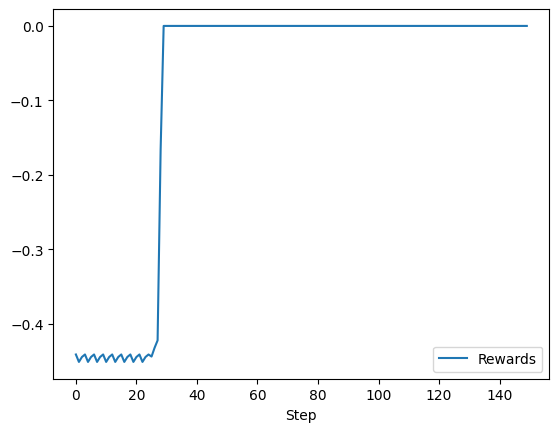

In [11]:
plt.plot(returns, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

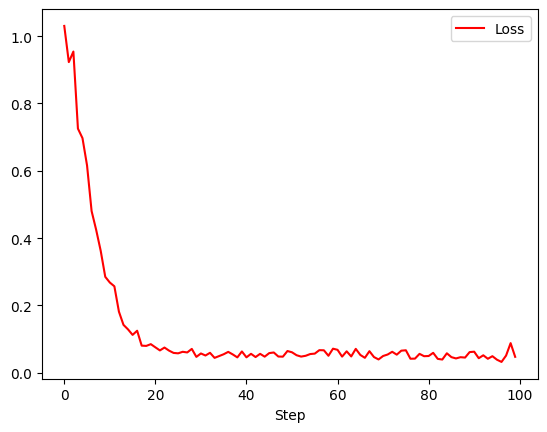

In [12]:
plt.plot(loss, label="Loss", c='r')
# plt.plot(returns, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

Save to checkpoint.

In [ ]:
# train_checkpointer.save(global_step)

### Restore checkpoint

In [ ]:
def test(policy, test_env, num_episodes: int=10000):
    rewards = []
    log_interval = 100
    time_step = test_env.reset()
    total_return = 0.0
    for i in tqdm(range(10000)):
        policy_state = policy.action(time_step)
        time_step = test_env.step(policy_state.action)
        reward = time_step.reward.numpy()[0]
        total_return += reward # Calculate a sum of rewards

        if i % log_interval == 0:
            # avg_return = compute_avg_return(eval_env, agent.policy, 10)
            avg_return = total_return / eval_interval
            print('step = {0}: Average reward = {1:.5f}'.format(step, avg_return))
            rewards.append(avg_return)
            total_return = 0.0 # reset
    return rewards

# test(agent.policy, test_env)